In [7]:
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
import os
import cv2

from utils import get_mask, downsample_mask, estimate_affine_transform, compute_border_color, upsample_warp_matrix, warp_image_with_affine

In [8]:
# get paths to test images
im_pth = 'test_data/cropped_sections'
images = sorted([os.path.join(im_pth, f) for f in os.listdir(im_pth) if f.endswith('.tif')])

In [9]:
# define parameters
ds = 8 # amount to downsize the mask by (improves speed)
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000, 1e-7)

# get paths to test images
im_pth = 'test_data/cropped_sections'
images = sorted([os.path.join(im_pth, f) for f in os.listdir(im_pth) if f.lower().endswith('.tif')])

# prepare output folder
out_dir = 'test_data/cropped_sections/aligned'
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

# save the first image to the output folder and get its mask
ref_path = images[0]
current_ref = imread(ref_path)
imwrite(os.path.join(out_dir, os.path.basename(ref_path)), current_ref)
current_ref_mask = get_mask(current_ref)

In [ ]:
# go through the rest of the images and align them
# start with first image we just saved
for img_path in images[1:]:
    mov = imread(img_path)
    mov_mask = get_mask(mov)

    # downsample masks
    r_ds = downsample_mask(current_ref_mask, ds)
    m_ds = downsample_mask(mov_mask, ds)

    # ECC on downsampled -> upsample warp
    warp_ds = estimate_affine_transform(r_ds, m_ds, criteria)
    M_full  = upsample_warp_matrix(warp_ds, ds)

    # compute fill color from moving image
    fill = compute_border_color(mov)

    # warp and save
    h, w = current_ref.shape[:2]
    aligned = warp_image_with_affine(mov, M_full, (w, h), fill)
    out_p  = os.path.join(out_dir, os.path.basename(img_path))
    imwrite(out_p, aligned)

    # update reference for next iteration
    current_ref = aligned
    current_ref_mask = get_mask(current_ref)

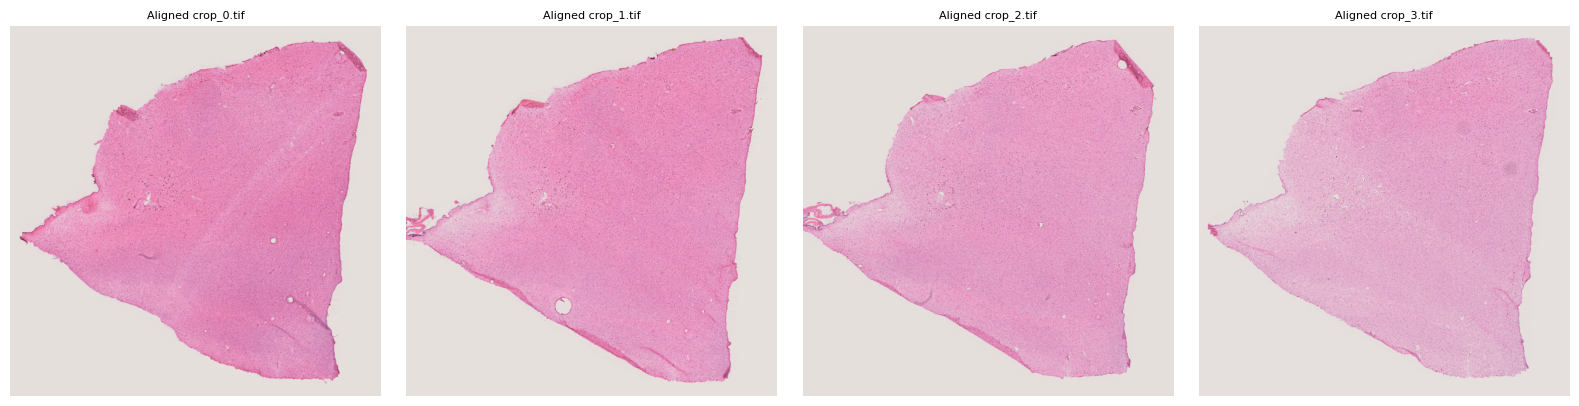

In [ ]:
# plot
aligned_im_path = 'test_data/cropped_sections/aligned'
aligned_ims = sorted([os.path.join(aligned_im_path, f) for f in os.listdir(aligned_im_path) if f.endswith('.tif')])

# Determine grid size: 4 columns, dynamic rows
n = len(aligned_ims)
cols = 4
rows = round(n / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

# Plot each image in its own subplot
for ax, img_path in zip(axes, aligned_ims):
    img = imread(img_path)
    ax.imshow(img)
    ax.set_title('Aligned ' + os.path.basename(img_path), fontsize=8)
    ax.axis('off')

# Turn off axes
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()